In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import copy
import math
from torchvision import datasets, models
from pathlib import Path
import torch.optim as optim
import torch.nn.utils.prune as prune
import pdb
import time
print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)
!mkdir data
data_dir = Path('./data')
net_fn = Path('./net')

import matplotlib.pyplot as plt
import os

torch.manual_seed(0)
np.random.seed(0)

PyTorch Version:  1.13.0+cu116
Torchvision Version:  0.14.0+cu116


Function to quantize MobileNetV2 model:

In [2]:
def quantize_model_mbnet(model):

    class ogMBNET(torch.nn.Module):
        def __init__(self, pretrained_model):
            super(ogMBNET, self).__init__()

            self.pretrained = pretrained_model
            self.quant = torch.quantization.QuantStub()
            self.dequant = torch.quantization.DeQuantStub()

        def forward(self, x):

            x = self.quant(x)
            x = self.pretrained(x)
            x = self.dequant(x)
            return x
            
    my_model = ogMBNET(model)
    my_model.eval() 
    my_model

    # TODO attach fbgemm config to model
    my_model.qconfig = torch.quantization.get_default_qconfig('fbgemm')

    # TODO Prepare model for quantization
    my_model_prepared = torch.quantization.prepare(my_model) 

    # TODO Run validation on prepared model for 1024 images
    with torch.inference_mode():
        for i, (inputs, labels) in enumerate(testloader):
            if (i >= 1024):
                break

            inputs = inputs.to("cpu")
            labels = labels.to("cpu")

            my_model_prepared = my_model_prepared.to("cpu")
            outputs = my_model_prepared(inputs)
            outputs = outputs.to("cpu")

    # TODO Convert model to quantized model
    my_model_int8 = torch.quantization.convert(my_model_prepared)

    return my_model_int8

In [3]:
'''
=============================================================================================================
Note from Arjun and Rakshana - 
This class defines the MobileNet Architecture.
It was borrowed from https://github.com/chenyaofo/pytorch-cifar-models.

The class was changed slightly as by default residual networks dont allow for 
direct quantization. This is because the residual addition does not support
quantised operation. So that part of the inverted residual block was changed 
to allow the model to be quantised.

The class definition as it is available online starts after this
=============================================================================================================


Modified from https://raw.githubusercontent.com/pytorch/vision/v0.9.1/torchvision/models/mobilenetv2.py

BSD 3-Clause License

Copyright (c) Soumith Chintala 2016,
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.

* Neither the name of the copyright holder nor the names of its
  contributors may be used to endorse or promote products derived from
  this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
'''
import sys
import torch
from torch import nn
from torch import Tensor
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url

from functools import partial
from typing import Dict, Type, Any, Callable, Union, List, Optional


cifar10_pretrained_weight_urls = {
    'mobilenetv2_x0_5': 'https://github.com/chenyaofo/pytorch-cifar-models/releases/download/mobilenetv2/cifar10_mobilenetv2_x0_5-ca14ced9.pt',
    'mobilenetv2_x0_75': 'https://github.com/chenyaofo/pytorch-cifar-models/releases/download/mobilenetv2/cifar10_mobilenetv2_x0_75-a53c314e.pt',
    'mobilenetv2_x1_0': 'https://github.com/chenyaofo/pytorch-cifar-models/releases/download/mobilenetv2/cifar10_mobilenetv2_x1_0-fe6a5b48.pt',
    'mobilenetv2_x1_4': 'https://github.com/chenyaofo/pytorch-cifar-models/releases/download/mobilenetv2/cifar10_mobilenetv2_x1_4-3bbbd6e2.pt',
}

cifar100_pretrained_weight_urls = {
    'mobilenetv2_x0_5': 'https://github.com/chenyaofo/pytorch-cifar-models/releases/download/mobilenetv2/cifar100_mobilenetv2_x0_5-9f915757.pt',
    'mobilenetv2_x0_75': 'https://github.com/chenyaofo/pytorch-cifar-models/releases/download/mobilenetv2/cifar100_mobilenetv2_x0_75-d7891e60.pt',
    'mobilenetv2_x1_0': 'https://github.com/chenyaofo/pytorch-cifar-models/releases/download/mobilenetv2/cifar100_mobilenetv2_x1_0-1311f9ff.pt',
    'mobilenetv2_x1_4': 'https://github.com/chenyaofo/pytorch-cifar-models/releases/download/mobilenetv2/cifar100_mobilenetv2_x1_4-8a269f5e.pt',
}


def _make_divisible(v: float, divisor: int, min_value: Optional[int] = None) -> int:
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class ConvBNActivation(nn.Sequential):
    def __init__(
        self,
        in_planes: int,
        out_planes: int,
        kernel_size: int = 3,
        stride: int = 1,
        groups: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        activation_layer: Optional[Callable[..., nn.Module]] = None,
        dilation: int = 1,
    ) -> None:
        padding = (kernel_size - 1) // 2 * dilation
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if activation_layer is None:
            activation_layer = nn.ReLU6
        super(ConvBNReLU, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, dilation=dilation, groups=groups,
                      bias=False),
            norm_layer(out_planes),
            activation_layer(inplace=True)
        )
        self.out_channels = out_planes


# necessary for backwards compatibility
ConvBNReLU = ConvBNActivation


class InvertedResidual(nn.Module):
    def __init__(
        self,
        inp: int,
        oup: int,
        stride: int,
        expand_ratio: int,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers: List[nn.Module] = []
        if expand_ratio != 1:
            # pw
            layers.append(ConvBNReLU(inp, hidden_dim, kernel_size=1, norm_layer=norm_layer))
        layers.extend([
            # dw
            ConvBNReLU(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim, norm_layer=norm_layer),
            # pw-linear
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            norm_layer(oup),
        ])
        self.conv = nn.Sequential(*layers)
        self.out_channels = oup
        self._is_cn = stride > 1
        self.skip_add = nn.quantized.FloatFunctional()


    def forward(self, x: Tensor) -> Tensor:
        if self.use_res_connect:
            # return x + self.conv(x)
            return self.skip_add.add(x, self.conv(x))
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(
        self,
        num_classes: int = 10,
        width_mult: float = 1.0,
        inverted_residual_setting: Optional[List[List[int]]] = None,
        round_nearest: int = 8,
        block: Optional[Callable[..., nn.Module]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        """
        MobileNet V2 main class

        Args:
            num_classes (int): Number of classes
            width_mult (float): Width multiplier - adjusts number of channels in each layer by this amount
            inverted_residual_setting: Network structure
            round_nearest (int): Round the number of channels in each layer to be a multiple of this number
            Set to 1 to turn off rounding
            block: Module specifying inverted residual building block for mobilenet
            norm_layer: Module specifying the normalization layer to use

        """
        super(MobileNetV2, self).__init__()

        if block is None:
            block = InvertedResidual

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        input_channel = 32
        last_channel = 1280

        if inverted_residual_setting is None:
            inverted_residual_setting = [
                # t, c, n, s
                [1, 16, 1, 1],
                [6, 24, 2, 1],  # NOTE: change stride 2 -> 1 for CIFAR10/100
                [6, 32, 3, 2],
                [6, 64, 4, 2],
                [6, 96, 3, 1],
                [6, 160, 3, 2],
                [6, 320, 1, 1],
            ]

        # only check the first element, assuming user knows t,c,n,s are required
        if len(inverted_residual_setting) == 0 or len(inverted_residual_setting[0]) != 4:
            raise ValueError("inverted_residual_setting should be non-empty "
                             "or a 4-element list, got {}".format(inverted_residual_setting))

        # building first layer
        input_channel = _make_divisible(input_channel * width_mult, round_nearest)
        self.last_channel = _make_divisible(last_channel * max(1.0, width_mult), round_nearest)
        features: List[nn.Module] = [ConvBNReLU(3, input_channel, stride=1, norm_layer=norm_layer)]  # NOTE: change stride 2 -> 1 for CIFAR10/100
        # building inverted residual blocks
        for t, c, n, s in inverted_residual_setting:
            output_channel = _make_divisible(c * width_mult, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, expand_ratio=t, norm_layer=norm_layer))
                input_channel = output_channel
        # building last several layers
        features.append(ConvBNReLU(input_channel, self.last_channel, kernel_size=1, norm_layer=norm_layer))
        # make it nn.Sequential
        self.features = nn.Sequential(*features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.last_channel, num_classes),
        )

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # This exists since TorchScript doesn't support inheritance, so the superclass method
        # (this one) needs to have a name other than `forward` that can be accessed in a subclass
        x = self.features(x)
        # Cannot use "squeeze" as batch-size can be 1
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _mobilenet_v2(
    arch: str,
    width_mult: List[int],
    model_urls: Dict[str, str],
    progress: bool = True,
    pretrained: bool = True,
    **kwargs: Any
) -> MobileNetV2:
    model = MobileNetV2(width_mult=width_mult, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def cifar10_mobilenetv2_x0_5(*args, **kwargs) -> MobileNetV2: pass
def cifar10_mobilenetv2_x0_75(*args, **kwargs) -> MobileNetV2: pass
def cifar10_mobilenetv2_x1_0(*args, **kwargs) -> MobileNetV2: pass
def cifar10_mobilenetv2_x1_4(*args, **kwargs) -> MobileNetV2: pass


def cifar100_mobilenetv2_x0_5(*args, **kwargs) -> MobileNetV2: pass
def cifar100_mobilenetv2_x0_75(*args, **kwargs) -> MobileNetV2: pass
def cifar100_mobilenetv2_x1_0(*args, **kwargs) -> MobileNetV2: pass
def cifar100_mobilenetv2_x1_4(*args, **kwargs) -> MobileNetV2: pass


thismodule = sys.modules[__name__]
for dataset in ["cifar10", "cifar100"]:
    for width_mult, model_name in zip([0.5, 0.75, 1.0, 1.4],
                                      ["mobilenetv2_x0_5", "mobilenetv2_x0_75", "mobilenetv2_x1_0", "mobilenetv2_x1_4"]):
        method_name = f"{dataset}_{model_name}"
        model_urls = cifar10_pretrained_weight_urls if dataset == "cifar10" else cifar100_pretrained_weight_urls
        num_classes = 10 if dataset == "cifar10" else 100
        setattr(
            thismodule,
            method_name,
            partial(_mobilenet_v2,
                    arch=model_name,
                    width_mult=width_mult,
                    model_urls=model_urls,
                    num_classes=num_classes)
        )

Preparing datasets and dataloaders:

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=False, num_workers=4)
                                
classes = ('plane', 'car', 'bird', 'cat','deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 4, shuffle = False, num_workers = 4)

Files already downloaded and verified


In [7]:
mbnet = cifar10_mobilenetv2_x1_4(pretrained = True)

Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/mobilenetv2/cifar10_mobilenetv2_x1_4-3bbbd6e2.pt" to /root/.cache/torch/hub/checkpoints/cifar10_mobilenetv2_x1_4-3bbbd6e2.pt


  0%|          | 0.00/16.8M [00:00<?, ?B/s]

Helper functions:
1. To get model size
2. To validate and produce accuracy for the model

In [8]:
def get_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    model_size = os.path.getsize("temp.p")/1e6
    os.remove('temp.p')
    print("Model size: ", model_size)
    return model_size

def validate_model(model, dataloader, device = "cuda", trials = 1):

    model.eval()

    dev = torch.device(device)
    model.to(dev)

    run_time = 0
    correct = 0
    total = 0 


    if (device == "cuda"):


      for i, (inputs, labels) in enumerate(dataloader):

        # print(i)

        #print(f"i = {i}")
        start = time.time()

        inputs = inputs.to(dev)
        labels = labels.to(dev)
        # an option can be of not sending the labels to GPU. Instead sending output back from GPU to CPU and getting the prediction on the CPU.

        
        outputs = model(inputs)
        torch.cuda.synchronize()
        # check torch.cuda.current_stream.synchronize()
        end = time.time()
        run_time += end - start
        # outputs = outputs.to("cpu") # an alternative here is ofc to send labels to GPU. 

        _, predicted = torch.max(outputs,1)

        predicted = predicted.to("cpu")
        labels = labels.to("cpu")

        correct += torch.sum(predicted == labels.data)
        total += inputs.size()[0]

        if i % 250 == 249:
          acc_local = 100 * correct.double() / total
          print(f"[{i+1}] accuracy : {acc_local:.4f}%")
        # in for loop
      #in the main fn

      run_time = run_time / trials
      accuracy = 100 * correct.double() / total

      torch.cuda.empty_cache()

    elif (device == "cpu"):
      for i, (inputs, labels) in enumerate(dataloader):

        # print(i)totalzeros = 0
        totalelements = 0
        start = time.time()
        # an option can be of not sending the labels to GPU. Instead sending output back from GPU to CPU and getting the prediction on the CPU.

        
        outputs = model(inputs)
        # check torch.cuda.current_stream.synchronize()
        end = time.time()
        run_time += end - start
        # outputs = outputs.to("cpu") # an alternative here is ofc to send labels to GPU. 

        _, predicted = torch.max(outputs,1)

        correct += torch.sum(predicted == labels.data)
        total += inputs.size()[0]

        if i % 250 == 249:
          acc_local = 100 * correct.double() / total
          print(f"[{i+1}] accuracy : {acc_local:.4f}%")
        # in for loop
      #in the main fn

      run_time = run_time / trials
      accuracy = 100 * correct.double() / total


    return run_time, accuracy

BatchNorm fusion function:

In [9]:
def fuse_bn_sequential(block):
    """
    This function takes a sequential block and fuses the batch normalization with convolution
    :param model: nn.Sequential. Source resnet model
    :return: nn.Sequential. Converted block
    """
    if not isinstance(block, nn.Sequential):
        return block
    stack = []
    for m in block.children():
        if isinstance(m, nn.BatchNorm2d):
            if isinstance(stack[-1], nn.Conv2d):
                bn_st_dict = m.state_dict()
                conv_st_dict = stack[-1].state_dict()

                # BatchNorm params
                eps = m.eps
                mu = bn_st_dict['running_mean']
                var = bn_st_dict['running_var']
                gamma = bn_st_dict['weight']

                if 'bias' in bn_st_dict:
                    beta = bn_st_dict['bias']
                else:
                    beta = torch.zeros(gamma.size(0)).float().to(gamma.device)

                # Conv params
                W = conv_st_dict['weight']
                if 'bias' in conv_st_dict:
                    bias = conv_st_dict['bias']
                else:
                    bias = torch.zeros(W.size(0)).float().to(gamma.device)

                denom = torch.sqrt(var + eps)
                b = beta - gamma.mul(mu).div(denom)
                A = gamma.div(denom)
                bias *= A
                A = A.expand_as(W.transpose(0, -1)).transpose(0, -1)

                W.mul_(A)
                bias.add_(b)

                stack[-1].weight.data.copy_(W)
                if stack[-1].bias is None:
                    stack[-1].bias = torch.nn.Parameter(bias)
                else:
                    stack[-1].bias.data.copy_(bias)

        else:
            stack.append(m)

    if len(stack) > 1:
        return nn.Sequential(*stack)
    else:
        return stack[0]


def fuse_bn_recursively(model):
    for module_name in model._modules:
        model._modules[module_name] = fuse_bn_sequential(model._modules[module_name])
        if len(model._modules[module_name]._modules) > 0:
            fuse_bn_recursively(model._modules[module_name])

    return model

Recording stats (runtime, accuracy, size) for original model: 

In [10]:
original = []

In [11]:
og_rntm, og_acc = validate_model(mbnet, testloader, device = "cuda")
original.append(og_acc.detach().numpy())
original.append(round(og_rntm,3))
m_size = get_size_of_model(mbnet)
original.append(round(m_size,3))

[250] accuracy : 83.8000%
[500] accuracy : 84.8000%
[750] accuracy : 83.9333%
[1000] accuracy : 83.7750%
[1250] accuracy : 84.1000%
[1500] accuracy : 83.9667%
[1750] accuracy : 83.9714%
[2000] accuracy : 84.1250%
[2250] accuracy : 84.0444%
[2500] accuracy : 84.1200%
Model size:  17.619481


Directly quantizing  original model and recording stats (runtime, accuracy, size):

In [12]:
mbnet_quant = quantize_model_mbnet(mbnet)

/usr/local/lib/python3.8/dist-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/ao/quantization/observer.py:1204: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(


In [13]:
normal_quant = []
quant_rntm, quant_acc = validate_model(mbnet_quant, testloader, device = "cpu")
normal_quant.append(quant_acc.detach().numpy())
normal_quant.append(round(quant_rntm,3))
normal_q_size = get_size_of_model(mbnet_quant)
normal_quant.append(round(normal_q_size,3))

[250] accuracy : 81.8000%
[500] accuracy : 82.2500%
[750] accuracy : 81.4667%
[1000] accuracy : 81.2750%
[1250] accuracy : 81.8800%
[1500] accuracy : 81.8000%
[1750] accuracy : 81.9857%
[2000] accuracy : 82.2625%
[2250] accuracy : 82.0333%
[2500] accuracy : 82.0800%
Model size:  5.245881


Loading original model:

In [14]:
mbnet = cifar10_mobilenetv2_x1_4(pretrained = True)

BatchNorm Fusion on original model:

In [15]:
mbnet_fused = fuse_bn_recursively(mbnet)

In [16]:
fused_rntm, fused_acc = validate_model(mbnet_fused, testloader, device = "cpu")


[250] accuracy : 83.8000%
[500] accuracy : 84.8000%
[750] accuracy : 83.9333%
[1000] accuracy : 83.7750%
[1250] accuracy : 84.1000%
[1500] accuracy : 83.9667%
[1750] accuracy : 83.9714%
[2000] accuracy : 84.1250%
[2250] accuracy : 84.0444%
[2500] accuracy : 84.1200%


AFCLE function for MobileNETV2:

In [17]:
block_list = []
for name, para in mbnet_fused.named_parameters():
    if ('conv' in name):
        split_name = list(name.split('.'))
        to_append = int(split_name[1])
        if (to_append not in block_list):
            block_list.append(to_append)

In [18]:
def BLOCK_AFCLE(model):

    for index in range(len(block_list)):

        print(block_list[index])
        block = model.features[block_list[index]]



        if (block_list[index] == 1):
            # in this case we just have 2 convs.

            while_loop_counter = 0
            

            while(1):

                s_sum  = 0
                s_running_mean = 0
                s_count = 0

                curr_layer = block.conv[0][0]
                next_layer = block.conv[1]

                curr_layer_num_out_ch = curr_layer.weight.shape[0]
                next_layer_num_in_ch = next_layer.weight.shape[1]

                curr_layer_weight_cloned = curr_layer.weight.clone()
                curr_layer_bias_cloned = curr_layer.bias.clone()
                next_layer_weight_cloned = next_layer.weight.clone()

                for channel in range(curr_layer_num_out_ch):

                    curr_out_ch = curr_layer_weight_cloned[channel, :, :, :]
                    next_in_ch = next_layer_weight_cloned[:, channel, :, :]
                    curr_layer_bias = curr_layer_bias_cloned[channel]

                    s = (math.sqrt( torch.max(torch.absolute(curr_out_ch)) * torch.max(torch.absolute(next_in_ch)) )) / (torch.max(torch.absolute(next_in_ch)))
                    s_count = s_count + 1
                    s_sum = s_sum + s

                    curr_layer_weight_cloned[channel, :, :, :] = curr_layer_weight_cloned[channel, :, :, :] * (1/(s.item()))
                    curr_layer_bias_cloned[channel] = curr_layer_bias_cloned[channel] * (1/(s.item()))
                    next_layer_weight_cloned[:, channel, :, :] = next_layer_weight_cloned[:, channel, :, :] * s.item()

                model.features[block_list[index]].conv[0][0].weight = torch.nn.Parameter(curr_layer_weight_cloned)
                model.features[block_list[index]].conv[0][0].bias = torch.nn.Parameter(curr_layer_bias_cloned)
                model.features[block_list[index]].conv[1].weight = torch.nn.Parameter(next_layer_weight_cloned)

                while_loop_counter = while_loop_counter + 1
                s_running_mean = s_sum / s_count
                print(f"Mean = {s_running_mean}, while loop count = {while_loop_counter}")
                if (torch.abs(s_running_mean - 1) < 1e-3 or (while_loop_counter == 100)):
                    break



        else:

            while_loop_counter = 0
            
            

            while(1):

                s_sum  = 0
                s_running_mean = 0
                s_count = 0

                curr_layer = block.conv[0][0]
                next_layer = block.conv[1][0]

                curr_layer_num_out_ch = curr_layer.weight.shape[0]
                next_layer_num_in_ch = next_layer.weight.shape[0]

                curr_layer_weight_cloned = curr_layer.weight.clone()
                curr_layer_bias_cloned = curr_layer.bias.clone()
                next_layer_weight_cloned = next_layer.weight.clone()

                for channel in range(curr_layer_num_out_ch):

                    curr_out_ch = curr_layer_weight_cloned[channel, :, :, :]
                    next_in_ch = next_layer_weight_cloned[channel, :, :, :]
                    curr_layer_bias = curr_layer_bias_cloned[channel]

                    s = (math.sqrt( torch.max(torch.absolute(curr_out_ch)) * torch.max(torch.absolute(next_in_ch)) )) / (torch.max(torch.absolute(next_in_ch)))
                    s_count = s_count + 1
                    s_sum = s_sum + s

                    curr_layer_weight_cloned[channel, :, :, :] = curr_layer_weight_cloned[channel, :, :, :] * (1/(s.item()))
                    curr_layer_bias_cloned[channel] = curr_layer_bias_cloned[channel] * (1/(s.item()))
                    next_layer_weight_cloned[channel, :, :, :] = next_layer_weight_cloned[channel, :, :, :] * s.item()

                model.features[block_list[index]].conv[0][0].weight = torch.nn.Parameter(curr_layer_weight_cloned)
                model.features[block_list[index]].conv[0][0].bias = torch.nn.Parameter(curr_layer_bias_cloned)
                model.features[block_list[index]].conv[1][0].weight = torch.nn.Parameter(next_layer_weight_cloned)

            
            
            

                # at this point we have equilised the first 2 conv layers.
                # now we need to equilise the 2nd and the 3rd conv layer.

                curr_layer = block.conv[1][0]
                next_layer = block.conv[2]

                curr_layer_num_out_ch = curr_layer.weight.shape[0]
                next_layer_num_in_ch = next_layer.weight.shape[1]

                curr_layer_weight_cloned = curr_layer.weight.clone()
                curr_layer_bias_cloned = curr_layer.bias.clone()
                next_layer_weight_cloned = next_layer.weight.clone()

                for channel in range(curr_layer_num_out_ch):

                    curr_out_ch = curr_layer_weight_cloned[channel, :, :, :]
                    next_in_ch = next_layer_weight_cloned[:, channel, :, :]
                    curr_layer_bias = curr_layer_bias_cloned[channel]

                    s = (math.sqrt( torch.max(torch.absolute(curr_out_ch)) * torch.max(torch.absolute(next_in_ch)) )) / (torch.max(torch.absolute(next_in_ch)))
                    s_count = s_count + 1
                    s_sum = s_sum + s

                    curr_layer_weight_cloned[channel, :, :, :] = curr_layer_weight_cloned[channel, :, :, :] * (1/(s.item()))
                    curr_layer_bias_cloned[channel] = curr_layer_bias_cloned[channel] * (1/(s.item()))
                    next_layer_weight_cloned[:, channel, :, :] = next_layer_weight_cloned[:, channel, :, :] * s.item()

                model.features[block_list[index]].conv[1][0].weight = torch.nn.Parameter(curr_layer_weight_cloned)
                model.features[block_list[index]].conv[1][0].bias = torch.nn.Parameter(curr_layer_bias_cloned)
                model.features[block_list[index]].conv[2].weight = torch.nn.Parameter(next_layer_weight_cloned)

                while_loop_counter = while_loop_counter + 1
                s_running_mean = s_sum / s_count
                print(f"Mean = {s_running_mean}, while loop count = {while_loop_counter}")
                if (torch.abs(s_running_mean - 1) < 1e-3 or (while_loop_counter == 100)):
                    break

    return model



Performing AFCLE Block wise on MobileNetV2 and recording stats (runtime, accuracy, size):

In [19]:
mbnet_fused_afcle = BLOCK_AFCLE(mbnet_fused)


1
Mean = 0.8273830413818359, while loop count = 1
Mean = 1.0, while loop count = 2
2
Mean = 0.6992543935775757, while loop count = 1
Mean = 0.9053948521614075, while loop count = 2
Mean = 0.9634703397750854, while loop count = 3
Mean = 0.9897823333740234, while loop count = 4
Mean = 0.9973716735839844, while loop count = 5
Mean = 0.9993383884429932, while loop count = 6
3
Mean = 0.6213281750679016, while loop count = 1
Mean = 0.8312838077545166, while loop count = 2
Mean = 0.942986249923706, while loop count = 3
Mean = 0.9844352602958679, while loop count = 4
Mean = 0.9960188865661621, while loop count = 5
Mean = 0.9989987015724182, while loop count = 6
Mean = 0.999749481678009, while loop count = 7
4
Mean = 0.669990599155426, while loop count = 1
Mean = 0.8972411751747131, while loop count = 2
Mean = 0.9622824192047119, while loop count = 3
Mean = 0.9895254969596863, while loop count = 4
Mean = 0.9973098635673523, while loop count = 5
Mean = 0.9993228316307068, while loop count = 6
5


In [20]:
fused_afcle_rntm, fused_afcle_acc = validate_model(mbnet_fused_afcle, testloader, device = "cuda")


[250] accuracy : 83.9000%
[500] accuracy : 84.8000%
[750] accuracy : 83.9333%
[1000] accuracy : 83.7750%
[1250] accuracy : 84.1200%
[1500] accuracy : 83.9667%
[1750] accuracy : 83.9714%
[2000] accuracy : 84.1250%
[2250] accuracy : 84.0444%
[2500] accuracy : 84.1200%


In [21]:
mbnet_fused_afcle_quant = quantize_model_mbnet(mbnet_fused_afcle)

In [22]:
afcle_quant_rntm, afcle_quant_acc = validate_model(mbnet_fused_afcle_quant, testloader, device = "cpu")

[250] accuracy : 82.4000%
[500] accuracy : 83.8500%
[750] accuracy : 83.2667%
[1000] accuracy : 82.9000%
[1250] accuracy : 83.2600%
[1500] accuracy : 83.1500%
[1750] accuracy : 83.3286%
[2000] accuracy : 83.5125%
[2250] accuracy : 83.3889%
[2500] accuracy : 83.5200%


In [23]:
afcle_quant = []
afcle_quant.append(afcle_quant_acc.detach().numpy())
afcle_quant.append(round(afcle_quant_rntm,3))
afcle_q_size = get_size_of_model(mbnet_fused_afcle_quant)
afcle_quant.append(round(afcle_q_size,3))

Model size:  4.867409


In [24]:
print(original)
print(normal_quant)
print(afcle_quant)

[array(84.12), 28.296, 17.619]
[array(82.08), 97.709, 5.246]
[array(83.52), 85.767, 4.867]


Plotting the results:

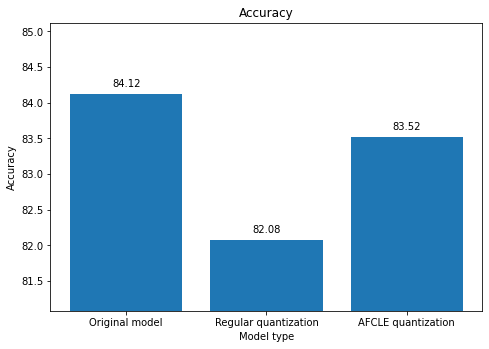

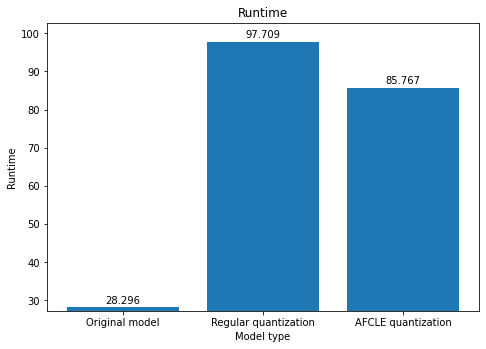

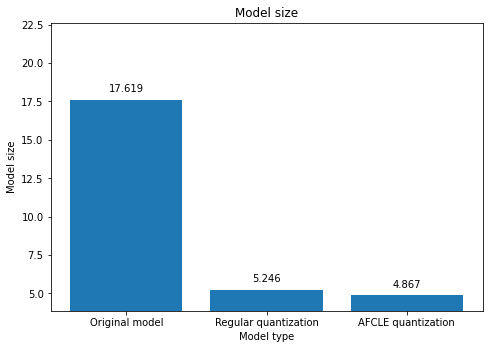

In [30]:
def addlabels(x,y,shift):
    for i in range(len(x)):
        plt.text(i, y[i]+shift, y[i], ha = 'center')

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
m_type = ['Original model', 'Regular quantization', 'AFCLE quantization']
data = [original[0],normal_quant[0],afcle_quant[0]]
ax.bar(m_type,data)
addlabels(m_type,data,0.1)
max_y_lim = max(data) + 1
min_y_lim = min(data) - 1
plt.ylim(min_y_lim, max_y_lim)
plt.xlabel("Model type")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
m_type = ['Original model', 'Regular quantization', 'AFCLE quantization']
data = [original[1],normal_quant[1],afcle_quant[1]]
ax.bar(m_type,data)
addlabels(m_type,data,1)
max_y_lim = max(data) + 5
min_y_lim = min(data) - 1
plt.ylim(min_y_lim, max_y_lim)
plt.xlabel("Model type")
plt.ylabel("Runtime")
plt.title("Runtime")
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
m_type = ['Original model', 'Regular quantization', 'AFCLE quantization']
data = [original[2],normal_quant[2],afcle_quant[2]]
ax.bar(m_type,data)
addlabels(m_type,data,0.5)
max_y_lim = max(data) + 5
min_y_lim = min(data) - 1
plt.ylim(min_y_lim, max_y_lim)
plt.xlabel("Model type")
plt.ylabel("Model size")
plt.title("Model size")
plt.show()